In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/study/16715robotsim/project/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Test
using Plots

In [49]:
const g = 9.8
const M = [1 0; 0 1]
μ = 0.5

# set of contact modes
modes = [0 0; # free
        1 0; # sticking
        1 -1; # left-slide
        1 1] # right-slide

q0 = [0;0.5]
dq0 = [0;0]
x0 = [q0;dq0]
initial_mode = [0 0]

n_contacts = 1


1

In [4]:
# constraints/contacts
function compute_a(q)
    a = q[2]
    return [a]
end

# constraints jacobian
function compute_A(q)
    A = [0 1]
    return A
end

function compute_dA(q, dq)
    dA = [0 0]
    return dA
end

function compute_A_tangent(q)
    A_t = [1 0]
    return A_t
end

function compute_dA_tangent(q, dq)
    dA_t = [0 0]
    return dA_t
end

compute_dA_tangent (generic function with 1 method)

In [7]:
println(compute_a(q0))
println(compute_A(q0))
println(compute_dA(q0, dq0))
println(compute_A_tangent(q0))
println(compute_dA_tangent(q0, dq0))

[0.5]
[0 1]
[0 0]
[1 0]
[0 0]


1-element Vector{Float64}:
 0.0

In [119]:
function contact_mode_constraints(x, contactMode)
    
    q = x[1:2]
    dq = x[3:4]
    
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    A = compute_A(q)
    A_t = compute_A_tangent(q)
    dA = compute_dA(q, dq)
    dA_t = compute_dA_tangent(q,dq)
    A = A[cs_mode,:]
    A_t = A_t[cs_mode,:]
    dA = dA[cs_mode,:]
    dA_t = dA_t[cs_mode,:]
    
    ss_active = ss_mode[cs_mode]
    
    A_all = zeros(0,2)
    A_all_f = zeros(0,2)
    dA_all = zeros(0,2)

    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            A_all_f = [A_all_f; A[k,:]'; A_t[k,:]']
            dA_all = [dA_all; dA[k,:]'; dA_t[k,:]']
            A_all = [A_all; A[k,:]'; A_t[k,:]']
        else
            A_all_f = [A_all_f; A[k,:]' - ss*μ*A_t[k,:]']
            dA_all = [dA_all; dA[k,:]']
            A_all = [A_all; A[k,:]']
        end
    end
    
    return A_all_f, A_all, dA_all
end

contact_mode_constraints (generic function with 1 method)

In [120]:
function contact_force_constraints(λ, contactMode)
    # c > 0
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    ss_active = ss_mode[cs_mode]
    
    i = 1
    i_c = 1
    c = zeros(sum(ss_active.==0)*3 + sum(ss_active.!=0))
    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            c[i:i+2] = [-λ[i]; -μ*λ[i] - λ[i+1]; -μ*λ[i] + λ[i+1]]
            i_c += 3
            i += 2
        else
            c[i] = -λ[i]
            i += 1
            i_c += 1
        end
    end
    return c
end

contact_force_constraints (generic function with 1 method)

In [202]:
function sliding_velocity_constraints(x, contactMode)
    # reture A_eq, A_geq, A_eq*dq = 0, A_geq*dq >= 0
    q = x[1:2]
    dq = x[3:4]
    
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    A = compute_A(q)
    A_t = compute_A_tangent(q)
    dA = compute_dA(q, dq)
    dA_t = compute_dA_tangent(q,dq)
    A = A[cs_mode,:]
    A_t = A_t[cs_mode,:]
    dA = dA[cs_mode,:]
    dA_t = dA_t[cs_mode,:]
    
    ss_active = ss_mode[cs_mode]
    
    AA_eq = zeros(0,2)
    AA_geq = zeros(0,2)
    dAA_eq = zeros(0,2)
    dAA_geq = zeros(0,2)

    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            AA_eq = [AA_eq; A[k,:]'; A_t[k,:]']
            dAA_eq = [dAA_eq; dA[k,:]'; dA_t[k,:]']
        else
            AA_eq = [AA_eq; A[k,:]']
            dAA_eq = [dAA_eq; dA[k,:]']
            AA_geq = [AA_geq; ss*A_t[k,:]']
            dAA_geq = [dAA_geq; ss*dA_t[k,:]']
        end
    end
    
    return AA_eq, AA_geq, dAA_eq, dAA_geq
end

sliding_velocity_constraints (generic function with 1 method)

In [203]:
println(contact_force_constraints([-1, -1],[1,0]))
println(contact_force_constraints([-1, 0.45],[1,0]))

[1.0, 1.5, -0.5]
[1.0, 0.04999999999999999, 0.95]


In [272]:
function solveEOM(x, contactMode)
    # contactMode: bool vector, indicates which constraints are active
    q = x[1:2]
    dq = x[3:4]
    
    A_f, A, dA = contact_mode_constraints(x, contactMode)
    
    # compute EOM matrices
    N = [0; g]
    C = [0 0; 0 0]
    Y = [0;0]
    
    #
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 

    b = [Y-N-C*dq; -dA*dq]
    
    z = blockMat\b
    
    ddq = z[1:2]
    if (sum(contactMode[1:n_contacts])>=1)
        λ = z[3:end]
    else
        λ = []
    end
    
    return ddq, λ
end

solveEOM (generic function with 1 method)

In [273]:
println(solveEOM([0;0.5;0;0],[0 0]))
println(solveEOM([0;0;0;0], [1 0]))
println(solveEOM([0;0.1;0;1], [1,1]))
println(solveEOM([0;-0.1;0;1], [1,-1]))

([0.0, -9.8], Any[])
([0.0, 0.0], [-9.8, -0.0])
([-4.9, 0.0], [-9.8])
([4.9, 0.0], [-9.8])


In [274]:
function computeResetMap(x, contactMode)
    q = x[1:2]
    dq = x[3:4]

    A_f, A, dA = contact_mode_constraints(x, contactMode)
    
    c = size(A, 1)
    #
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 
    
    z = blockMat\[M*dq; zeros(c)]
    
    dq_p = z[1:2]
    p_hat = z[3:end]
    return dq_p, p_hat
end

computeResetMap (generic function with 1 method)

In [275]:
dq_p, p_hat = computeResetMap([0;0;1;-1], [1 1])
println(contact_force_constraints(p_hat,[1 1]))

[1.0]


In [276]:
function compute_FA(x)
    
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    
    active_cs = abs.(a) .< 1e-6
    inactive_cs = abs.(a) .> 1e-6
    
    possibleModes = zeros(Bool, 0, size(modes,2))
    
    contactMode = zeros(n_contacts*2)
    
    for k = 1:size(modes,1)
        m_cs = modes[k, 1:n_contacts].==1
        if length(findall(z->z==true, m_cs[inactive_cs])) == 0
            possibleModes = [possibleModes; modes[k, :]']
        end
    end
    
    for kk = 1:size(possibleModes, 1)
        
        m = possibleModes[kk,:]
        
        separate_cs = (m[1:n_contacts].!=1) .& active_cs
        _, A_separate, dA_separate = contact_mode_constraints(x, [separate_cs; ones(n_contacts)]) 

        ddq, λ = solveEOM(x, m)
        
        c_λ = contact_force_constraints(λ, m)
        As_eq, As_geq, dAs_eq, dAs_geq = sliding_velocity_constraints(x, m)
        
        sep_vel_cond = ((A_separate*dq).>0) .| ((A_separate*ddq .+ dA_separate*dq).>=0)
        maintain_vel_cond = all(abs.(As_eq*dq).<1e-6) & all((As_geq*dq).>1e-6)
        if ~maintain_vel_cond
            if all((As_geq*dq).<1e-6)
                maintain_vel_cond = all(abs.(dAs_eq*dq + As_eq*ddq).<1e-6) & all((dAs_geq*dq + As_geq*ddq).>0)
            end
        end
        
        if all(c_λ.>=0) && all(sep_vel_cond) && maintain_vel_cond
            contactMode = m
            break;
        end
    end
    
    return contactMode
end

compute_FA (generic function with 1 method)

In [277]:
println(compute_FA([0;0;0;0]))
println(compute_FA([0;0;-10;0]))
println(compute_FA([0;0;-10;10]))

[1, 0]
[1, 0]
[0, 0]


In [278]:
function compute_IV(x)
    
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    
    active_cs = abs.(a) .< 1e-6
    inactive_cs = abs.(a) .> 1e-6
    
    possibleModes = zeros(Bool, 0, size(modes,2))
    
    contactMode = zeros(n_contacts*2)
    
    for k = 1:size(modes,1)
        m_cs = modes[k, 1:n_contacts].==1
        if length(findall(z->z==true, m_cs[inactive_cs])) == 0
            possibleModes = [possibleModes; modes[k, :]']
        end
    end
    
    for kk = 1:size(possibleModes, 1)
        
        m = possibleModes[kk,:]
        
        separate_cs = (m[1:n_contacts].!=1) .& active_cs
        _, A_separate, _ = contact_mode_constraints(x, [separate_cs; ones(n_contacts)]) 

        dq_p, p_hat = computeResetMap(x, m)
        
        c_p_hat = contact_force_constraints(p_hat, m)
        As_eq, As_geq, _, _ = sliding_velocity_constraints(x, m)
        
        if all(c_p_hat.>=0) && all(A_separate*dq_p.>=0) && all(abs.(As_eq*dq_p).<1e-6) && all(As_geq*dq_p.>0)
            contactMode = m
            break;
        end
    end
    
    return contactMode
end

compute_IV (generic function with 1 method)

In [279]:
println(compute_IV([0;1;0;-1]))
println(compute_IV([0;0;-1;-1]))
println(compute_IV([0;0;1;-1]))
println(compute_IV([0;0;0.4;-1]))
println(compute_IV([0;1;-1;1]))
println(compute_IV([0;0;0;0]))

[0, 0]
[1, -1]
[1, 1]
[1, 0]
[0, 0]
[0, 0]


In [311]:
function guard_conditions(x, contactMode)
    q = x[1:2]
    dq = x[3:4]
    
    a = compute_a(q)
    a[contactMode[1:n_contacts] .== 1] .= 0.0
    
    v_all = zeros(n_contacts)
    _, As_geq, _, _ = sliding_velocity_constraints(x, contactMode)
    v_all[1:size(As_geq,1)] = -As_geq*dq
    
    ddq, λ = solveEOM(x, contactMode)
    c_λ = contact_force_constraints(λ, contactMode)
    c_λ_all = zeros(3*n_contacts)
    c_λ_all[1:length(c_λ)] = c_λ
    
    c = [a; v_all; c_λ_all]
    
    dir = [-ones(Int,length(a)); ones(Int,length(v_all)); ones(Int,length(c_λ_all))]
    
    return c, dir
end

guard_conditions (generic function with 1 method)

In [312]:
guard_conditions([0;0;1;0],[1 0])

([0.0, 0.0, 9.8, 4.9, 4.9], [-1, 1, 1, 1, 1])

In [313]:
d = [1 2]
d .= reshape(compute_IV([0;0;0;0]),size(d))

1×2 Matrix{Int64}:
 0  0

In [314]:
function dynamics!(dx, x, m, t)
    # m: vector n, contact mode
    q = x[1:2]
    dq = x[3:4]
    ddq, λ = solveEOM(x, m)
    dx .= [dq; ddq]
end

dynamics! (generic function with 1 method)

In [315]:
function conditions(out, x, t, integrator)
    contactMode = integrator.p
    c, dir = guard_conditions(x, contactMode)
    out .= c
end

function affect!(integrator, idx)
    contactMode = integrator.p
    x = integrator.u
    c, dir = guard_conditions(x, contactMode)
    
    # only consider upcrossing forces and constraints values(FA comp)
    # forces
    if dir[idx] > 0
        new_contactMode = compute_FA(x)
        integrator.p .= reshape(new_contactMode,size(integrator.p))
    end
    # constraints
#     if dir[idx] < 0
#         new_contactMode = contactMode
#         new_contactMode[idx] = false
#     end
end

function affect_neg!(integrator, idx)
    contactMode = integrator.p
    x = integrator.u
    c, dir = guard_conditions(x, contactMode)
    
    # only consider down crossing constraint value(IV comp)
    if dir[idx] < 0
        new_contactMode = compute_IV(x)
        dq_p, p_hat = computeResetMap(x, new_contactMode)
        integrator.u .= [x[1:2]; dq_p]
        integrator.p .= reshape(new_contactMode,size(integrator.p))
    end
end

affect_neg! (generic function with 1 method)

In [329]:
tspan = (0.0, 5.0)
callback_length = 5*n_contacts

x0 = [0;0.3;-5;0]
initial_mode = [0 0]
prob = ODEProblem(dynamics!, x0, tspan, initial_mode)
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 32-element Vector{Float64}:
 0.0
 0.0002830825555844335
 0.0007413150239812603
 0.0014351248238311954
 0.002445844892536925
 0.0038910077521538506
 0.0059188303376915274
 0.0087155067590237
 0.012511789583777046
 0.0175913127179647
 0.024300604147905743
 0.033060361434814556
 0.044382224763717525
 ⋮
 0.24743582965269686
 0.29969831200217667
 0.37305654061904525
 0.46033381229576964
 0.5698493538437197
 0.6983614928666017
 0.8514294953346635
 1.0204081632653068
 1.0204081632653068
 1.1962731468692982
 2.954922982909212
 5.0
u: 32-element Vector{Vector{Float64}}:
 [0.0, 0.3, -5.0, 0.0]
 [-0.0014154127779221672, 0.29999960733490694, -5.0, -0.002774209044727447]
 [-0.003706575119906301, 0.2999973072149726, -5.0, -0.007264887235016349]
 [-0.007175624119155976, 0.29998990804202613, -5.0, -0.014064223273545711]
 [-0.012229224462684624, 0.2999706874295321, -5.0, -0.02396927994686186]
 [-0.01945503876076925, 0.2999258

┌ Info: Saved animation to 
│   fn = /home/xianyi/study/16715robotsim/project/src/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/study/16715robotsim/project/src/anim.gif")
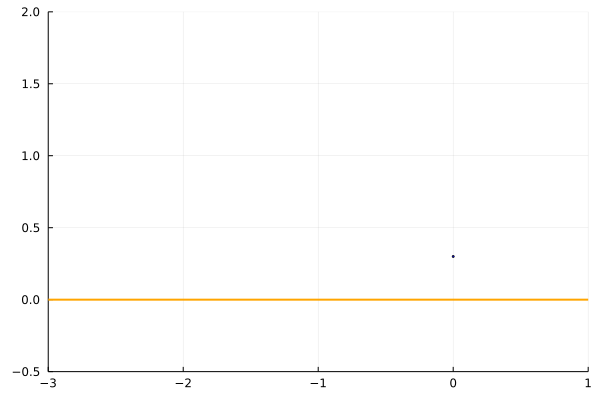

In [331]:
# animation 
n = length(sol.t)
x = zeros(n)
y = zeros(n)
for k = 1:n
    x[k] = sol.u[k][1]
    y[k] = sol.u[k][2]
end
    
plot([-10,5],[0,0], lw = 2, c=:orange, xlims=(-3,1), ylims=(-0.5,2))
anim = @animate for i ∈ 1:n
    
    scatter!([x[i]], [y[i]],
         m=:circle, c=:blue,
         markersize=2, legend = false)
    
end
gif(anim, "anim.gif", fps = 1/(tspan[2]/n))